#### Lab assignment 1a Classification with a single-layer perceptron

Installs

In [ ]:
!pip install numpy matplotlib
!pip install jupyterlab

Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt

### Generation of linearly-separable data

In [4]:
def generate_binary_data(n=100, mA=(1.0, 0.5), sigmaA=0.5, mB=(-1.0, 0.0), sigmaB=0.5, plot=True, seed=None):
    
    if seed is not None:
        np.random.seed(seed)

    # Generate class A
    classA_x = np.random.randn(n) * sigmaA + mA[0]
    classA_y = np.random.randn(n) * sigmaA + mA[1]
    classA = np.column_stack((classA_x, classA_y))

    # Generate class B
    classB_x = np.random.randn(n) * sigmaB + mB[0]
    classB_y = np.random.randn(n) * sigmaB + mB[1]
    classB = np.column_stack((classB_x, classB_y))

    # Labels
    labelsA = np.zeros(n)  # class A = 0
    labelsB = np.ones(n)   # class B = 1

    # Combine dataset
    data = np.vstack((classA, classB))
    labels = np.hstack((labelsA, labelsB))

    # Shuffle dataset
    indices = np.random.permutation(len(data))
    data = data[indices]
    labels = labels[indices]

    # Plot if requested
    if plot:
        plt.figure(figsize=(6,6))
        plt.scatter(classA[:,0], classA[:,1], c='red', label='Class A')
        plt.scatter(classB[:,0], classB[:,1], c='blue', label='Class B')
        plt.title('Linearly Separable 2D Data')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.legend()
        plt.grid(True)
        plt.show()

    return data, labels


Example

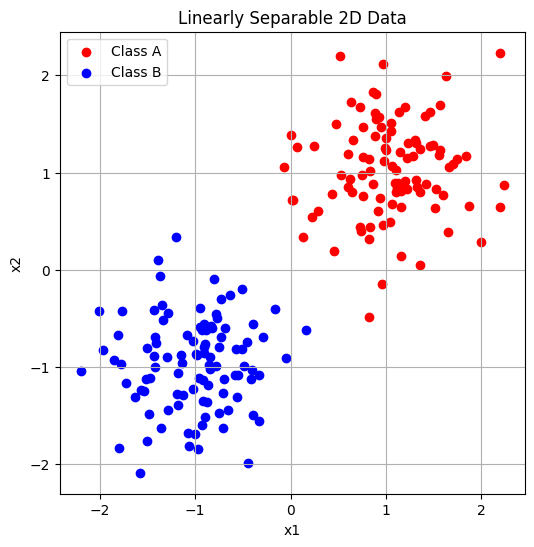

Data shape: (200, 2)
Labels shape: (200,)
First 5 samples:
 [[ 1.66579325  1.05873783]
 [-0.86780265 -1.1815931 ]
 [ 1.33011578  0.85618529]
 [-1.50235818 -1.75753784]
 [-0.7059797  -1.6304139 ]]
First 5 labels: [0. 1. 0. 1. 1.]


In [5]:
data, labels = generate_binary_data(n=100, mA=(1.0, 1.0), sigmaA=0.5, mB=(-1.0, -1.0), sigmaB=0.5, plot=True, seed=10)

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
print("First 5 samples:\n", data[:5])
print("First 5 labels:", labels[:5])

### Classification with a single-layer perceptron and analysis

Bias

In [6]:
def add_bias(X):
    """Add a bias column of ones to the dataset."""
    return np.hstack([X, np.ones((X.shape[0], 1))])

Plot decision boundery

In [7]:
def plot_decision_boundary(X, y, w, bias=True, title="Decision boundary"):
    plt.figure(figsize=(6,6))
    plt.scatter(X[y==0,0], X[y==0,1], c="red", label="Class A (0)")
    plt.scatter(X[y==1,0], X[y==1,1], c="blue", label="Class B (1)")
    
    x_vals = np.linspace(X[:,0].min()-1, X[:,0].max()+1, 100)
    if w[1] != 0:
        if bias:
            # w[0] = weight for x1, w[1] = weight for x2, w[2] = bias
            y_vals = -(w[0]*x_vals + w[2]) / w[1]
        else:
            # no bias term
            y_vals = -(w[0]*x_vals) / w[1]
        plt.plot(x_vals, y_vals, "k--", label="Boundary")
    
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [8]:
def plot_learning_curves(curves, title="Learning curves", ylabel="Misclassification rate"):
    plt.figure(figsize=(6,4))
    for label, values in curves.items():
        plt.plot(values, label=label)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


Perceptron (Only changes if its wrong)

In [9]:
def perceptron_train(X, y, epochs=20, lr=0.01, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    # Convert labels: 0 -> -1, 1 -> +1
    y_bin = np.where(y==0, -1, 1)
    Xb = add_bias(X)
    w = np.random.randn(Xb.shape[1]) * 0.01  # init weights
    
    misclass = []
    for _ in range(epochs):
        epoch_mis = 0
        for i in range(len(y_bin)):
            xi, target = Xb[i], y_bin[i]
            output = np.sign(np.dot(w, xi))
            if output == 0: output = -1
            if output != target: # If output != target: w += w + η target xi​
                w += lr * target * xi
                epoch_mis += 1 # Counts misclassified points in the current epoch
        misclass.append(epoch_mis / len(y_bin)) # Tracks the fraction of misclassified samples per epoch
    return w, misclass


Delta rule sequential (Updates sequentially)

In [10]:
def delta_rule_seq(X, y, epochs=20, lr=0.01, seed=None):
    if seed is not None:
        np.random.seed(seed)

    y_bin = np.where(y==0, -1, 1)
    Xb = add_bias(X)
    w = np.random.randn(Xb.shape[1]) * 0.01
    
    misclass = []
    for _ in range(epochs):
        epoch_mis = 0
        for i in range(len(y_bin)):
            xi, target = Xb[i], y_bin[i]
            output = np.dot(w, xi)
            w += lr * (target - output) * xi # x upphöjt?
            pred = np.sign(output)
            if pred == 0: pred = -1
            if pred != target:
                epoch_mis += 1
        misclass.append(epoch_mis / len(y_bin))
    return w, misclass


Delta rule Batch (Updates after going through all the data points)

In [11]:
def delta_rule_batch(X, y, epochs=20, lr=0.001, seed=None, bias=True):
    if seed is not None:
        np.random.seed(seed)
    
    y_bin = np.where(y==0, -1, 1).reshape(-1,1) # Needs reshape in batch
    Xb = add_bias(X) if bias else X # Added option to remove bias for 3rd step
    w = np.random.randn(Xb.shape[1], 1) * 0.01
    
    misclass = []
    for _ in range(epochs):
        # Batch update
        w -= lr * (Xb.T @ (Xb @ w - y_bin))
        preds = np.sign((Xb @ w).flatten())
        preds[preds==0] = -1
        misclass.append(np.mean(preds != y_bin.flatten())) # final weights as 1D array
    return w.flatten(), misclass


Perception vs delta rule sequential vs delta rule batch

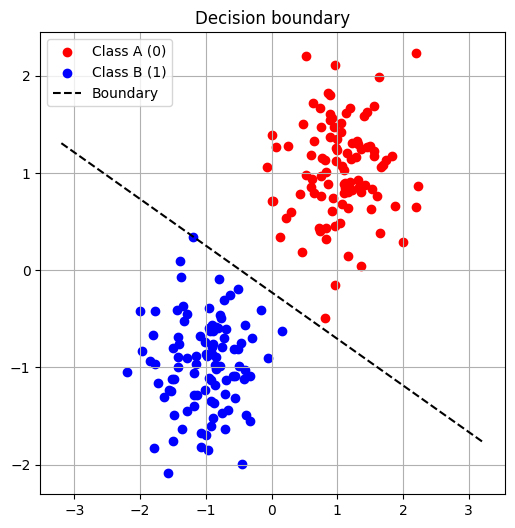

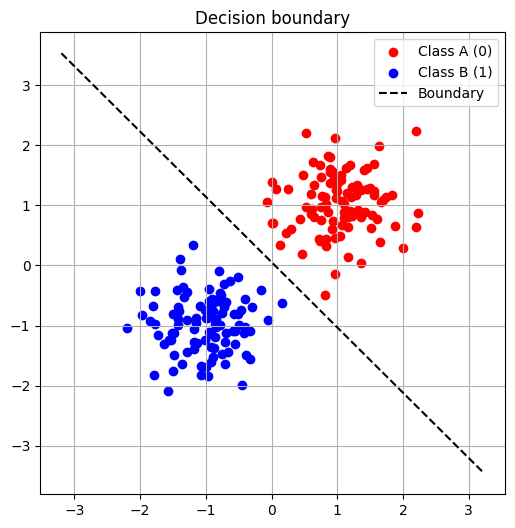

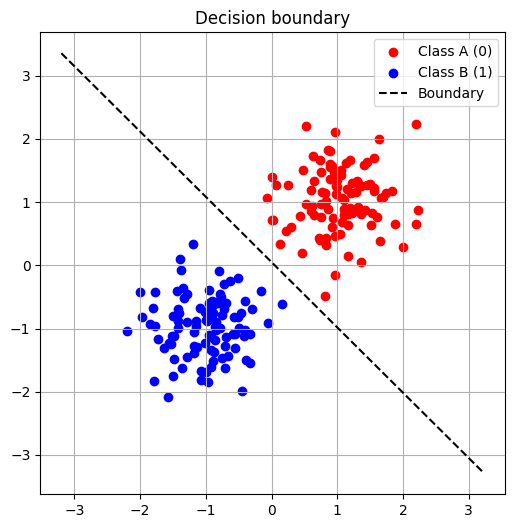

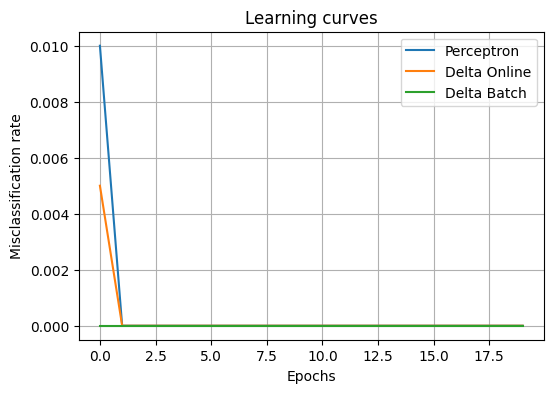

In [ ]:
X, y = data, labels

# Perceptron
w_p, err_p = perceptron_train(X, y, epochs=20, lr=0.01, seed=1)
plot_decision_boundary(X, y, w_p, "Perceptron Boundary")

# Delta Online
w_do, err_do = delta_rule_seq(X, y, epochs=20, lr=0.01, seed=1)
plot_decision_boundary(X, y, w_do, "Delta Online Boundary")

# Delta Batch
w_db, err_db = delta_rule_batch(X, y, epochs=20, lr=0.001, seed=1)
plot_decision_boundary(X, y, w_db, "Delta Batch Boundary")

# Compare learning curves
"""plot_learning_curves({
    "Perceptron": err_p,
    "Delta Online": err_do,
    "Delta Batch": err_db
})"""


Delta rule Batch no bias

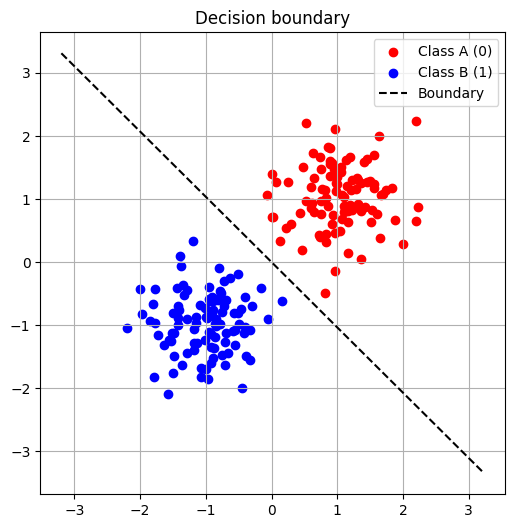

In [16]:
# Delta Batch
w_db, err_db = delta_rule_batch(X, y, epochs=20, lr=0.001, seed=1, bias=False)
plot_decision_boundary(X, y, w_db, bias=False)

### 3.1.3

Non inseperatable data

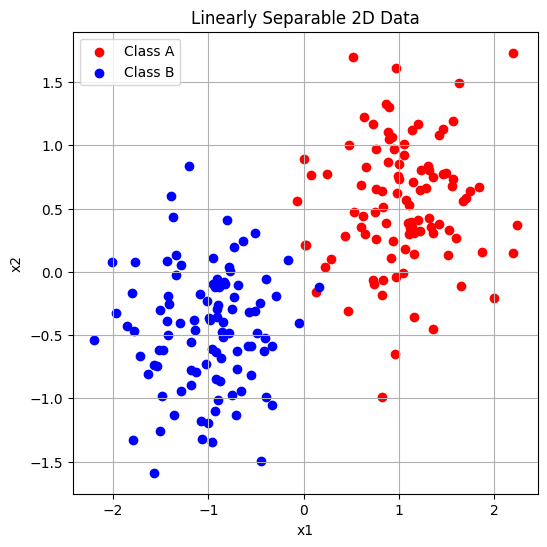

Data shape: (200, 2)
Labels shape: (200,)
First 5 samples:
 [[ 1.66579325  0.55873783]
 [-0.86780265 -0.6815931 ]
 [ 1.33011578  0.35618529]
 [-1.50235818 -1.25753784]
 [-0.7059797  -1.1304139 ]]
First 5 labels: [0. 1. 0. 1. 1.]


In [18]:
data2, labels2 = generate_binary_data(n=100, mA=(1.0, 0.5), sigmaA=0.5, mB=(-1.0, -0.5), sigmaB=0.5, plot=True, seed=10)

print("Data shape:", data2.shape)
print("Labels shape:", labels2.shape)
print("First 5 samples:\n", data2[:5])
print("First 5 labels:", labels2[:5])

Subsampling scenarios

In [19]:
def subsample_data(X, y, scenario, seed=None):
    rng = np.random.default_rng(seed)
    idx_A = np.where(y==0)[0]
    idx_B = np.where(y==1)[0]
    
    if scenario == 1:
        keep_A = rng.choice(idx_A, size=int(0.75*len(idx_A)), replace=False)
        keep_B = rng.choice(idx_B, size=int(0.75*len(idx_B)), replace=False)
    elif scenario == 2:
        keep_A = rng.choice(idx_A, size=int(0.5*len(idx_A)), replace=False)
        keep_B = idx_B
    elif scenario == 3:
        keep_A = idx_A
        keep_B = rng.choice(idx_B, size=int(0.5*len(idx_B)), replace=False)
    elif scenario == 4:
        A_left = idx_A[X[idx_A,0] < 0]
        A_right = idx_A[X[idx_A,0] >= 0]
        keep_A_left = rng.choice(A_left, size=int(0.8*len(A_left)), replace=False)
        keep_A_right = rng.choice(A_right, size=int(0.2*len(A_right)), replace=False)
        keep_A = np.concatenate([keep_A_left, keep_A_right])
        keep_B = idx_B
    else:
        raise ValueError("Invalid scenario")
    
    keep_idx = np.concatenate([keep_A, keep_B])
    return X[keep_idx], y[keep_idx]


Experiments

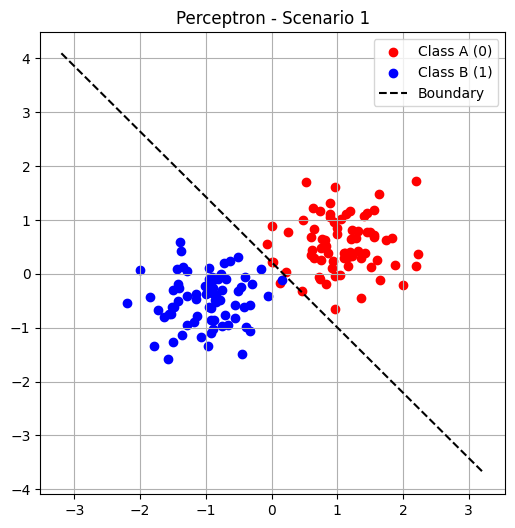

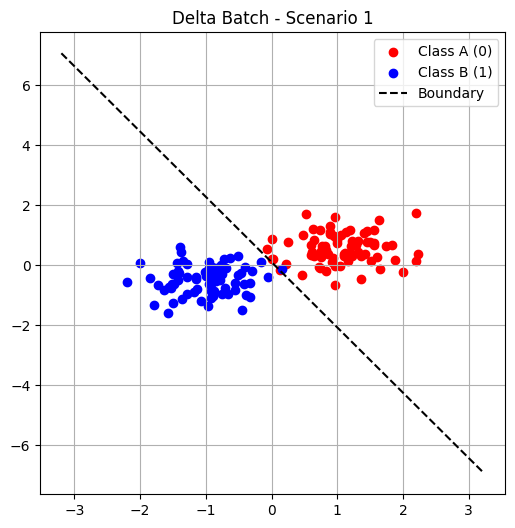

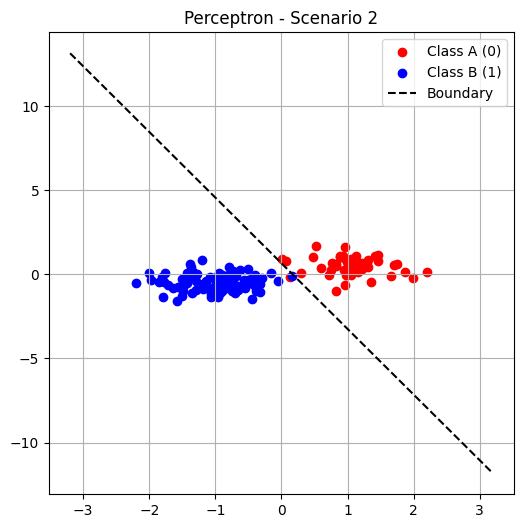

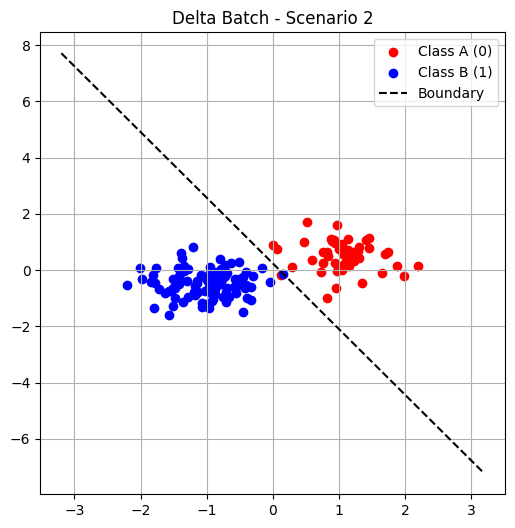

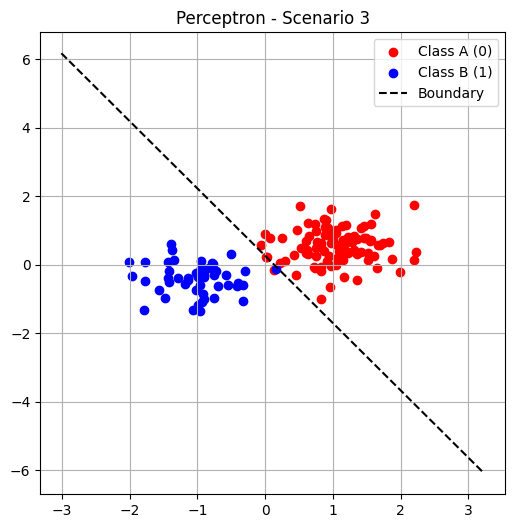

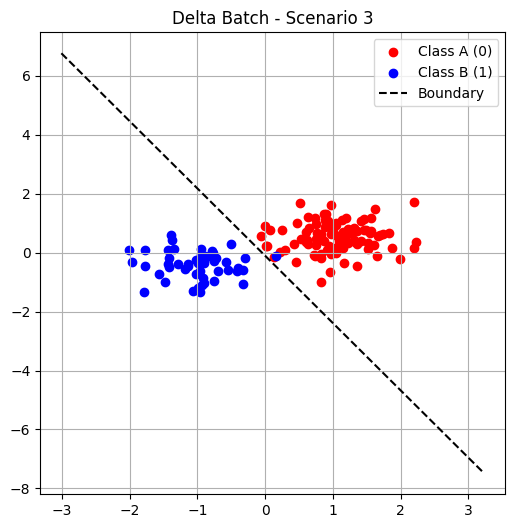

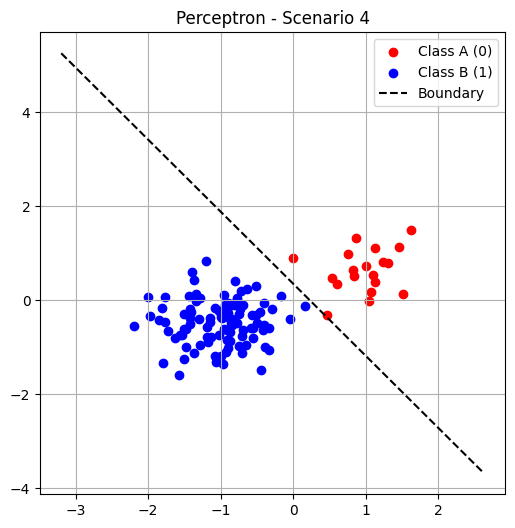

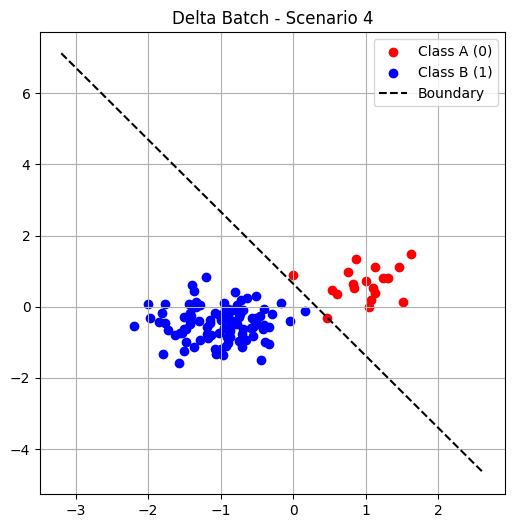

In [20]:
X, y = data2, labels2

for scenario in [1,2,3,4]:
    X_sub, y_sub = subsample_data(X, y, scenario, seed=42)
    
    # Train perceptron
    w_p, mis_p = perceptron_train(X_sub, y_sub, epochs=50)
    
    # Train delta rule (batch)
    w_d, mis_d = delta_rule_batch(X_sub, y_sub, epochs=50)
    
    # Compare boundaries + misclassification rates
    plot_decision_boundary(X_sub, y_sub, w_p, bias=True, title=f"Perceptron - Scenario {scenario}")
    plot_decision_boundary(X_sub, y_sub, w_d, bias=True, title=f"Delta Batch - Scenario {scenario}")
